In [1]:
# Bibliotecas Gerais
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
import matplotlib.pyplot as plt

# TensorFlow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

In [2]:
# Ler dados
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')


In [3]:
## CODIGO DE TESTE ##


# Função para dividir o nome do file e extrair informações
def extract_features_from_filename(filename):
    parts = filename.split('_')

    def clean_coordinate(coordinate):
        """Remove hyphens and convert to float if possible."""
        clean_coord = coordinate.replace('-', '')
        try:
            return float(clean_coord)
        except ValueError:
            return clean_coord


    if len(parts) == 11:
        coordinates_id1 = clean_coordinate(parts[4])
        coordinates_id2 = clean_coordinate(parts[5])
        date_time_acquisition_start = parts[8].replace('T', '')
        date_time_acquisition_end = parts[9].replace('T', '')
        return pd.Series([coordinates_id1, coordinates_id2, date_time_acquisition_start, date_time_acquisition_end], 
                         index=['coordinates_id1', 'coordinates_id2', 'date_time_acquisition_start', 'date_time_acquisition_end'])

    if len(parts) == 10:
        coordinates_id1 = clean_coordinate(parts[3])
        coordinates_id2 = clean_coordinate(parts[4])
        date_time_acquisition_start = parts[7].replace('T', '')
        date_time_acquisition_end = parts[8].replace('T', '')
        return pd.Series([coordinates_id1, coordinates_id2, date_time_acquisition_start, date_time_acquisition_end], 
                         index=['coordinates_id1', 'coordinates_id2', 'date_time_acquisition_start', 'date_time_acquisition_end'])

    if len(parts) == 9:
        coordinates_id1 = clean_coordinate(parts[2])
        coordinates_id2 = clean_coordinate(parts[3])
        date_time_acquisition_start = parts[6].replace('T', '')
        date_time_acquisition_end = parts[7].replace('T', '')
        return pd.Series([coordinates_id1, coordinates_id2, date_time_acquisition_start, date_time_acquisition_end], 
                         index=['coordinates_id1', 'coordinates_id2', 'date_time_acquisition_start', 'date_time_acquisition_end'])

    if len(parts) == 8:
        coordinates_id1 = clean_coordinate(parts[1])
        coordinates_id2 = clean_coordinate(parts[2])
        date_time_acquisition_start = parts[5].replace('T', '')
        date_time_acquisition_end = parts[6].replace('T', '')
        return pd.Series([coordinates_id1, coordinates_id2, date_time_acquisition_start, date_time_acquisition_end], 
                         index=['coordinates_id1', 'coordinates_id2', 'date_time_acquisition_start', 'date_time_acquisition_end'])

    return pd.Series([None]*4, index=['coordinates_id1', 'coordinates_id2', 'date_time_acquisition_start', 'date_time_acquisition_end'])

# Aplicar a função a cada nome de arquivo no dataset
file_features = train_data['file_name_l1'].apply(extract_features_from_filename)
file_features_test = test_data['file_name_l1'].apply(extract_features_from_filename)

# Concatenar as novas features ao dataframe original

train_data = pd.concat([train_data, file_features], axis=1)
test_data = pd.concat([test_data, file_features_test], axis=1)


In [4]:

# Remover colunas 'id' e 'file_name_l1'

train_data = train_data.drop(columns=['id', 'file_name_l1'])
test_data = test_data.drop(columns=['file_name_l1'])

In [ ]:

# Estatísticas descritivas
print("Estatísticas Descritivas do Dataset de Treino:")
desc_stats = train_data.describe()
print(desc_stats.to_string())
print("\n")

# Verificar valores nulos
print("Verificar Missing Data:")
missing_data = train_data.isnull().sum()
print(missing_data.to_string())


In [ ]:
# Graficos e Visualizações

#Visualizar a distribuição normal das features
df_analise_dist = train_data.melt()

#Histograma para cada feature do DataSet
g = sns.FacetGrid(df_analise_dist, col="variable", col_wrap=4, sharex=False, sharey=False, height=4)
g.map(sns.histplot, "value", kde=False, color='blue', bins=30)
plt.show()


#Visualizar a distribuição de outliers
df_analise_box_plot = train_data.melt()

#FaceGrit com os box Plot
g = sns.FacetGrid(df_analise_box_plot, col="variable", col_wrap=4, sharex=False, sharey=False, height=4)
g.map(sns.boxplot, "value")
plt.show()
        

# Visualizações (dependendo do tipo de dados, ajuste as visualizações)
sns.pairplot(train_data)
plt.show()

In [12]:
# Traino e Validation Set´s
X = train_data.drop(columns=['value_550'])
y = train_data['value_550']

# Dividir os dados de treino completos em treino e validação
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=10)


# Standardizar as features dos dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)


In [ ]:
# Modelo mais imporatne foi descobrir o batch_size correcto, aumentando a eficencia do modelo em termos de parametros a serem lidos e divididos.

# aplicar cross valdiation dentro do modelo tmb foi importante

# aplicar regularizaçao l1 ao incio mais forte e l2 no final

# aplciar dropout para evitar overfitting de acordo copm o nr de neuronios

# nr de neuroniuos a diminiar e regularizaçao tmb para evitar perdas de informaçao importante

# 550 epoch para permitir minimizar o erro com uma paciencia de 25 epochs.

# perceber o val los e vaml mean para perceber se o modelo esta a aprender bem ou nao de acordo com o validation set aplicado

# confirmar a prendizagam nos plos a cada fold do modelo

Epoch 1/550


C:\Users\Jojo\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 2.4172 - mae: 1.0375 - val_loss: 0.6208 - val_mae: 0.1258
Epoch 2/550
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.6543 - mae: 0.7987 - val_loss: 0.6086 - val_mae: 0.0953
Epoch 3/550
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.4279 - mae: 0.7108 - val_loss: 0.6068 - val_mae: 0.1028
Epoch 4/550
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.2381 - mae: 0.6240 - val_loss: 0.6117 - val_mae: 0.1278
Epoch 5/550
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.2001 - mae: 0.5973 - val_loss: 0.6270 - val_mae: 0.1721
Epoch 6/550
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0948 - mae: 0.5477 - val_loss: 0.6353 - val_mae: 0.1889
Epoch 7/550
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0360 - mae: 0.5184 - val_loss: 0.6545 - val_mae: 0.2260
Epoch 8/550
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9987 - mae: 0.4935 - val_loss: 0.6632 - val_mae: 0.2391
Epoch 9/550
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9561 - mae: 0.

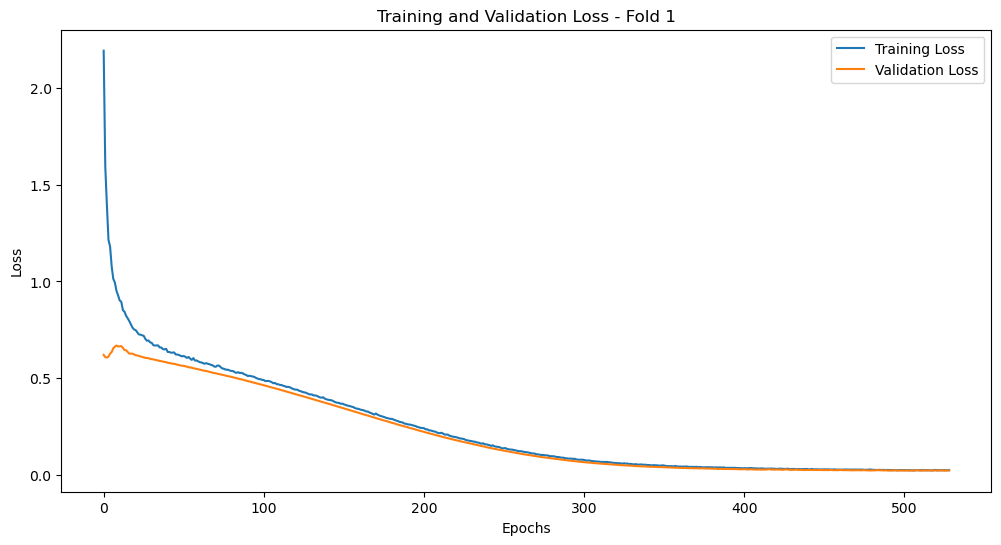

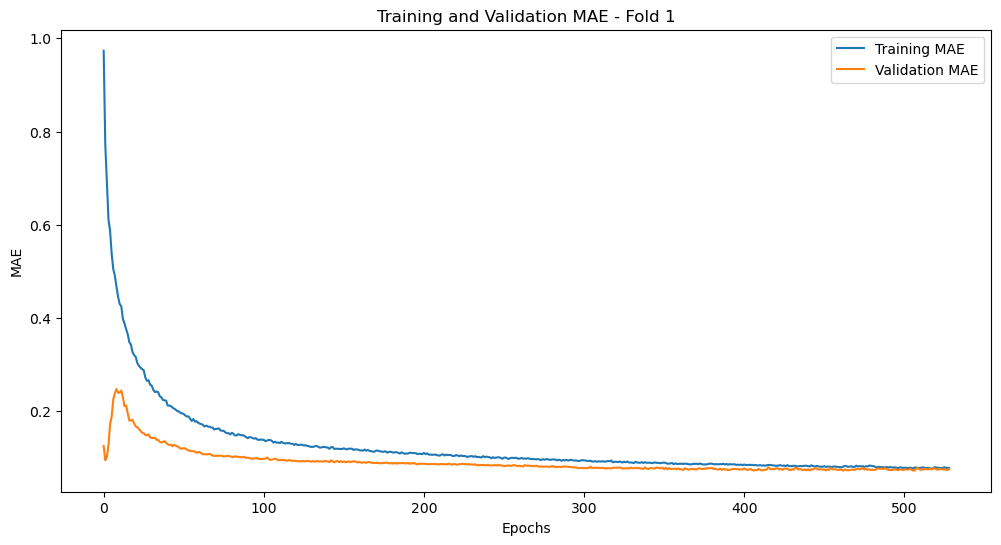

Fold Validation MAE: 0.07552334666252136
Epoch 1/550


C:\Users\Jojo\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 1.9508 - mae: 0.8822 - val_loss: 0.6201 - val_mae: 0.0935
Epoch 2/550
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.3978 - mae: 0.6970 - val_loss: 0.6230 - val_mae: 0.1331
Epoch 3/550
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.2244 - mae: 0.6065 - val_loss: 0.6367 - val_mae: 0.1844
Epoch 4/550
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1261 - mae: 0.5649 - val_loss: 0.6516 - val_mae: 0.2238
Epoch 5/550
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0428 - mae: 0.5193 - val_loss: 0.6622 - val_mae: 0.2471
Epoch 6/550
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9980 - mae: 0.4913 - val_loss: 0.6701 - val_mae: 0.2619
Epoch 7/550
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9576 - mae: 0.4708 - val_loss: 0.6706 - val_mae: 0.2623
Epoch 8/550
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9246 - mae: 0.4453 - val_loss: 0.6690 - val_mae: 0.2578
Epoch 9/550
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8947 - mae: 0.

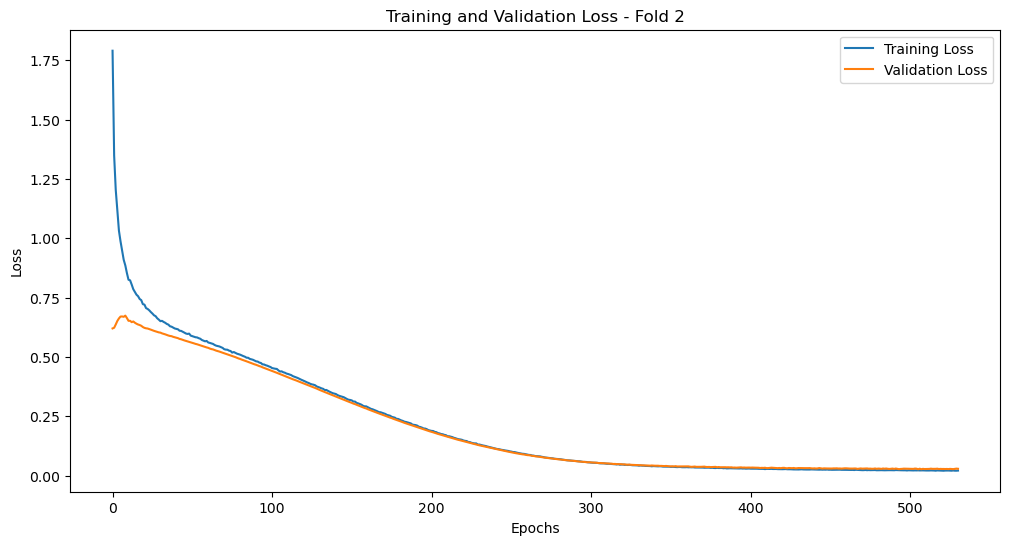

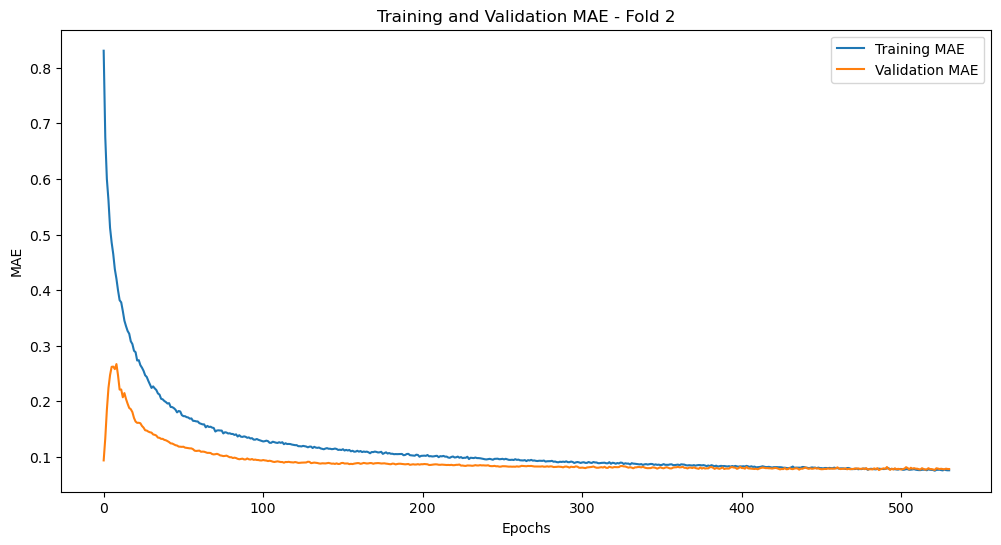

Fold Validation MAE: 0.07729173451662064
Epoch 1/550


C:\Users\Jojo\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 2.2343 - mae: 0.9897 - val_loss: 0.6269 - val_mae: 0.1166
Epoch 2/550
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.6400 - mae: 0.7972 - val_loss: 0.6221 - val_mae: 0.1077
Epoch 3/550
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.3767 - mae: 0.6892 - val_loss: 0.6197 - val_mae: 0.1090
Epoch 4/550
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.2007 - mae: 0.6092 - val_loss: 0.6194 - val_mae: 0.1136
Epoch 5/550
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0923 - mae: 0.5594 - val_loss: 0.6199 - val_mae: 0.1186
Epoch 6/550
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0513 - mae: 0.5348 - val_loss: 0.6206 - val_mae: 0.1244
Epoch 7/550
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0106 - mae: 0.5042 - val_loss: 0.6220 - val_mae: 0.1290
Epoch 8/550
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9530 - mae: 0.4681 - val_loss: 0.6251 - val_mae: 0.1363
Epoch 9/550
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9157 - mae: 0.

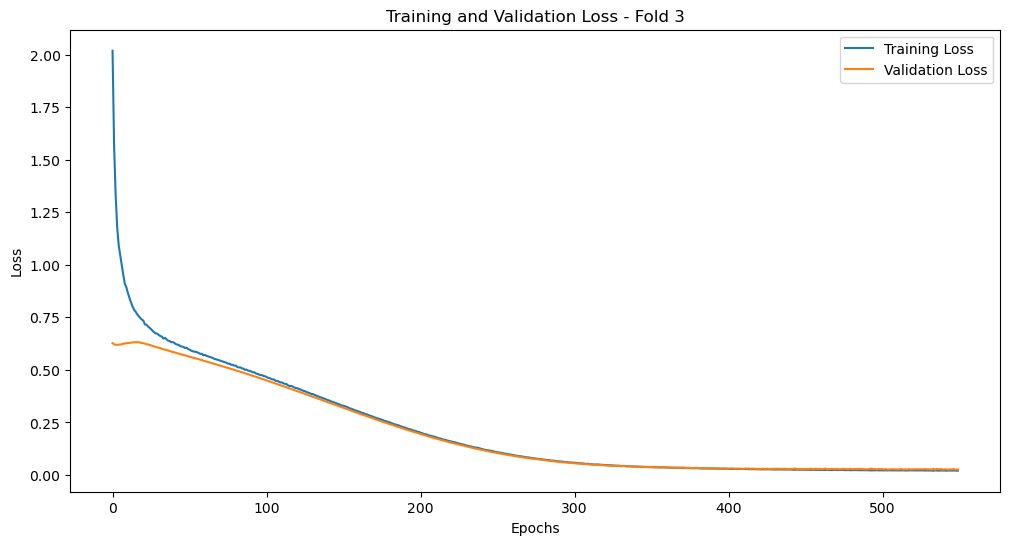

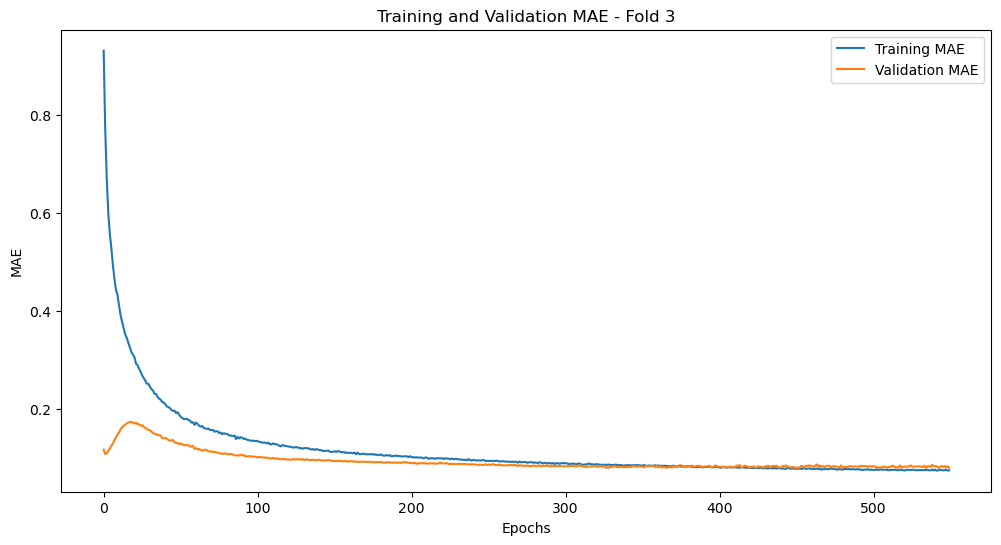

Fold Validation MAE: 0.07875368744134903
Epoch 1/550


C:\Users\Jojo\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 2.0807 - mae: 0.9398 - val_loss: 0.6281 - val_mae: 0.0995
Epoch 2/550
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.5025 - mae: 0.7422 - val_loss: 0.6264 - val_mae: 0.1240
Epoch 3/550
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.2629 - mae: 0.6382 - val_loss: 0.6296 - val_mae: 0.1446
Epoch 4/550
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.1719 - mae: 0.5904 - val_loss: 0.6334 - val_mae: 0.1606
Epoch 5/550
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0873 - mae: 0.5477 - val_loss: 0.6372 - val_mae: 0.1719
Epoch 6/550
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0495 - mae: 0.5236 - val_loss: 0.6433 - val_mae: 0.1905
Epoch 7/550
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9845 - mae: 0.4913 - val_loss: 0.6440 - val_mae: 0.1897
Epoch 8/550
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9422 - mae: 0.4649 - val_loss: 0.6468 - val_mae: 0.1944
Epoch 9/550
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8929 - mae: 0.

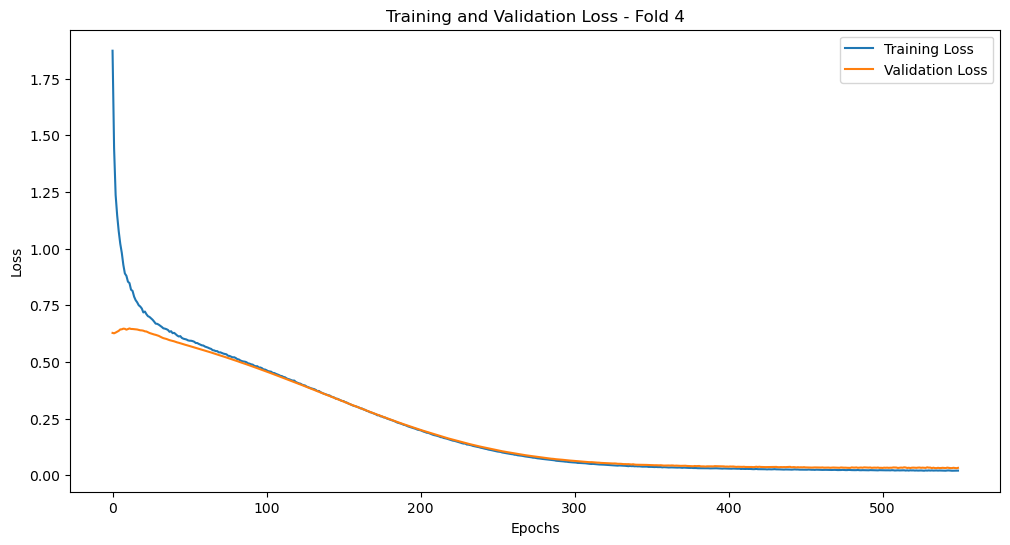

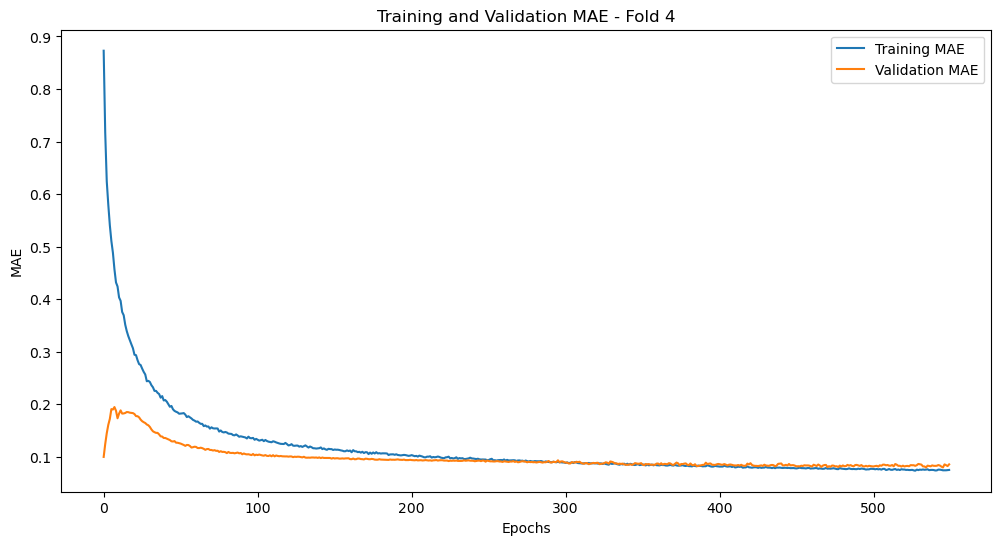

Fold Validation MAE: 0.08206795901060104
Epoch 1/550


C:\Users\Jojo\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 2.0202 - mae: 0.9308 - val_loss: 0.6204 - val_mae: 0.1061
Epoch 2/550
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.4926 - mae: 0.7345 - val_loss: 0.6122 - val_mae: 0.0939
Epoch 3/550
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.2905 - mae: 0.6537 - val_loss: 0.6109 - val_mae: 0.1117
Epoch 4/550
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1830 - mae: 0.6007 - val_loss: 0.6144 - val_mae: 0.1316
Epoch 5/550
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0801 - mae: 0.5501 - val_loss: 0.6155 - val_mae: 0.1348
Epoch 6/550
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0579 - mae: 0.5292 - val_loss: 0.6204 - val_mae: 0.1511
Epoch 7/550
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9737 - mae: 0.4860 - val_loss: 0.6269 - val_mae: 0.1695
Epoch 8/550
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9411 - mae: 0.4631 - val_loss: 0.6302 - val_mae: 0.1765
Epoch 9/550
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9013 - mae: 0.

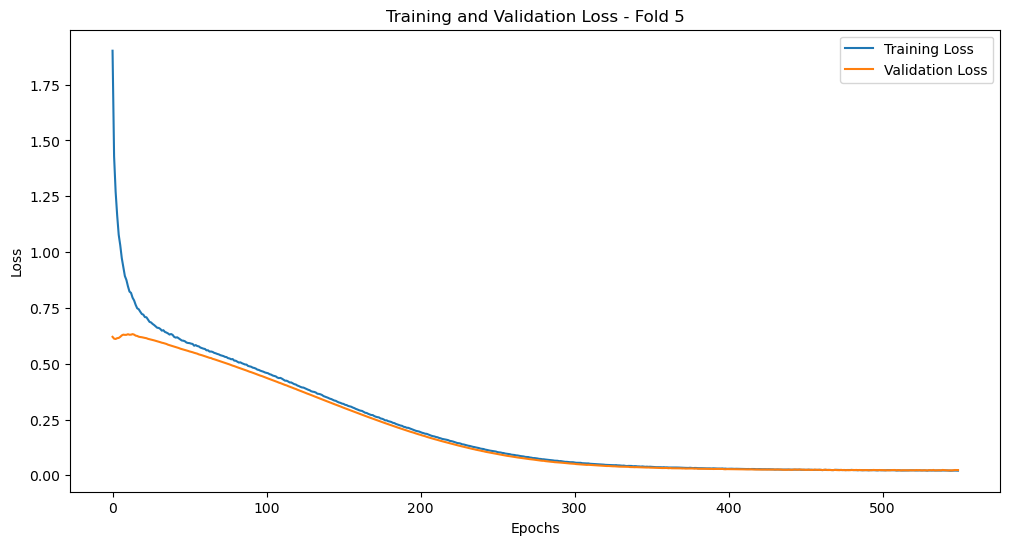

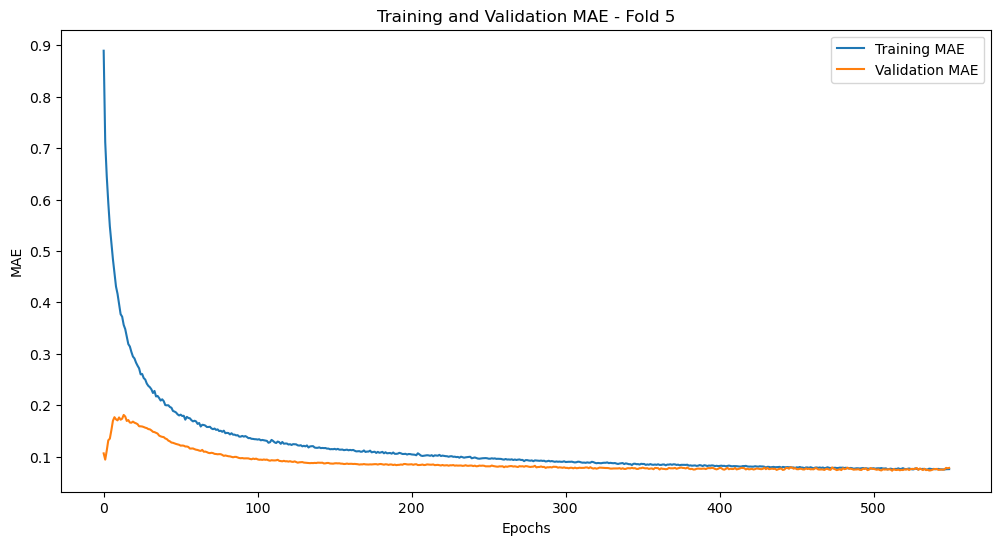

Fold Validation MAE: 0.07414516061544418
Epoch 1/550


C:\Users\Jojo\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 2.7213 - mae: 1.1230 - val_loss: 0.6303 - val_mae: 0.1094
Epoch 2/550
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.8083 - mae: 0.8625 - val_loss: 0.6268 - val_mae: 0.1028
Epoch 3/550
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.5746 - mae: 0.7591 - val_loss: 0.6259 - val_mae: 0.1049
Epoch 4/550
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.3540 - mae: 0.6800 - val_loss: 0.6261 - val_mae: 0.1092
Epoch 5/550
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.2621 - mae: 0.6321 - val_loss: 0.6247 - val_mae: 0.1118
Epoch 6/550
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.1637 - mae: 0.5839 - val_loss: 0.6255 - val_mae: 0.1188
Epoch 7/550
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0612 - mae: 0.5332 - val_loss: 0.6329 - val_mae: 0.1361
Epoch 8/550
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0266 - mae: 0.5084 - val_loss: 0.6348 - val_mae: 0.1428
Epoch 9/550
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9761 - mae: 0.

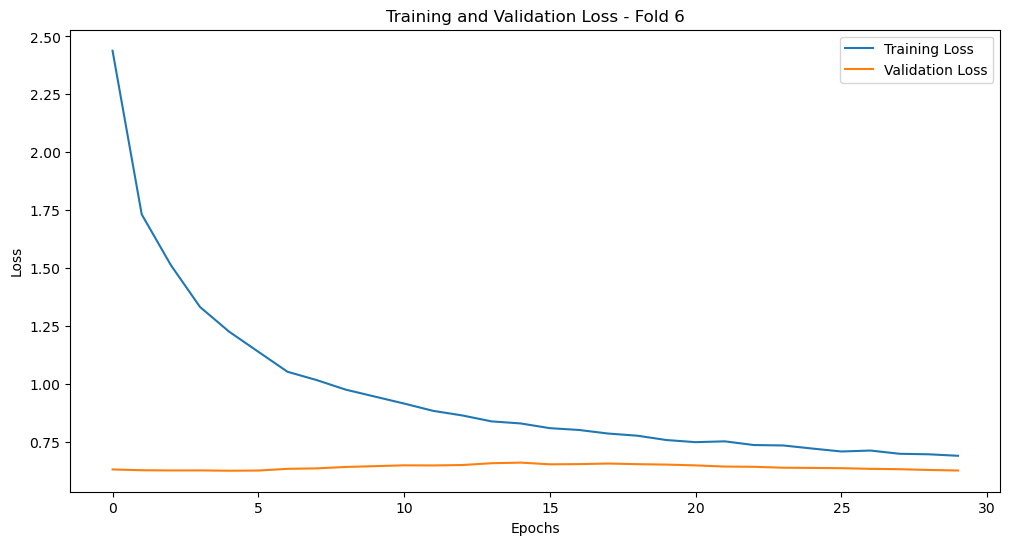

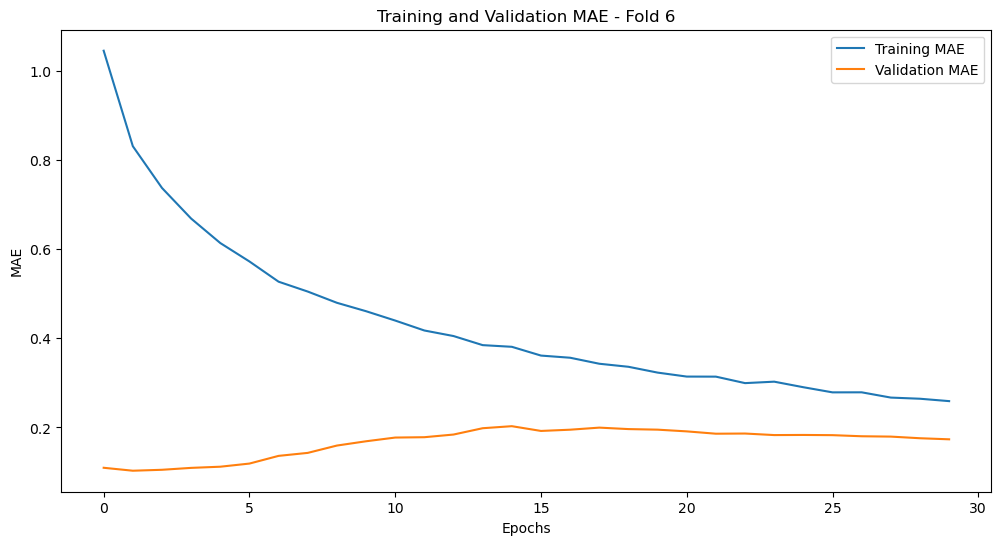

Fold Validation MAE: 0.11179506778717041
Epoch 1/550


C:\Users\Jojo\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 1.8731 - mae: 0.8719 - val_loss: 0.6279 - val_mae: 0.1178
Epoch 2/550
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.4118 - mae: 0.6935 - val_loss: 0.6177 - val_mae: 0.0912
Epoch 3/550
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1780 - mae: 0.5914 - val_loss: 0.6155 - val_mae: 0.0953
Epoch 4/550
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0546 - mae: 0.5226 - val_loss: 0.6154 - val_mae: 0.1165
Epoch 5/550
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9709 - mae: 0.4751 - val_loss: 0.6184 - val_mae: 0.1355
Epoch 6/550
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9269 - mae: 0.4472 - val_loss: 0.6209 - val_mae: 0.1461
Epoch 7/550
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8831 - mae: 0.4133 - val_loss: 0.6260 - val_mae: 0.1645
Epoch 8/550
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8619 - mae: 0.4026 - val_loss: 0.6314 - val_mae: 0.1800
Epoch 9/550
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8214 - mae: 0.

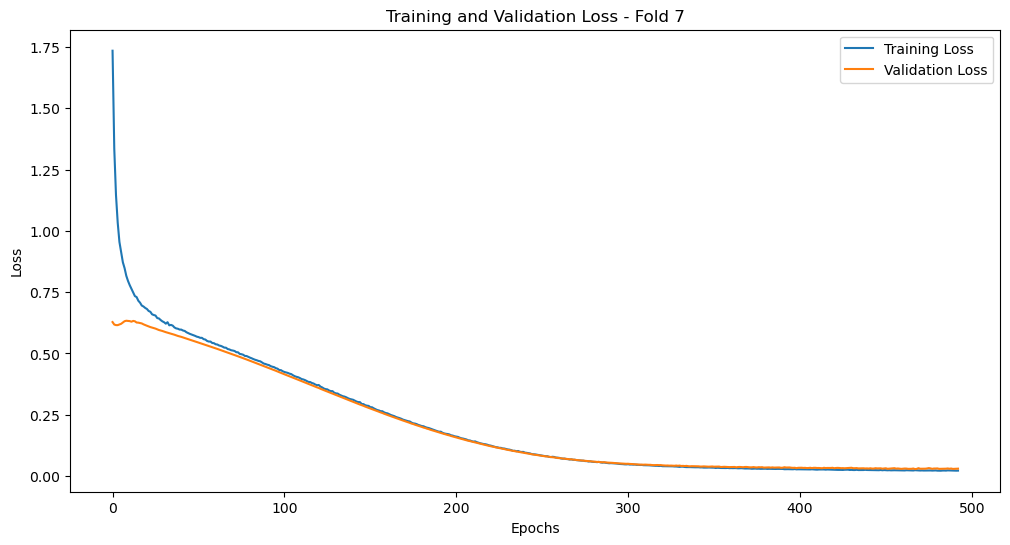

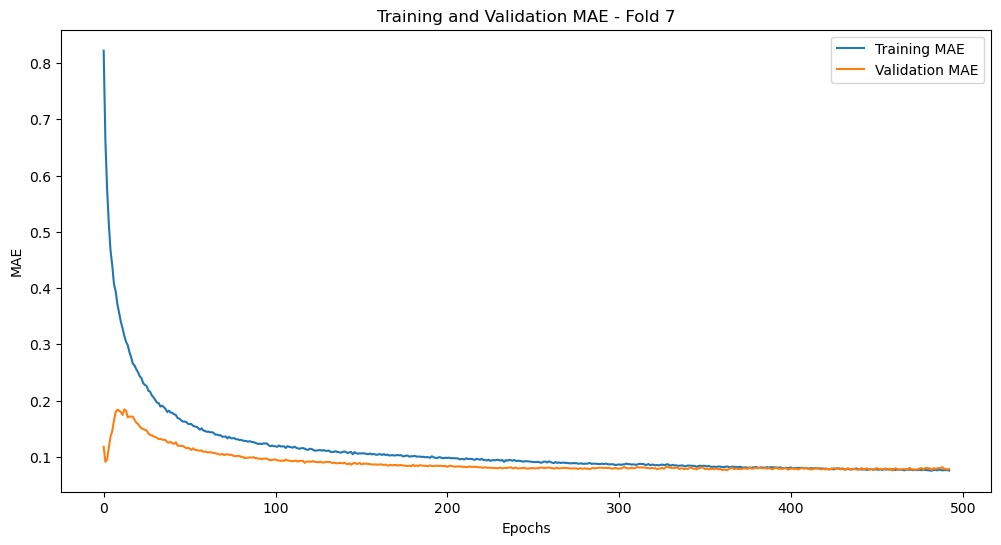

Fold Validation MAE: 0.07746117562055588
Epoch 1/550


C:\Users\Jojo\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 2.5015 - mae: 1.0373 - val_loss: 0.6166 - val_mae: 0.1104
Epoch 2/550
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.7518 - mae: 0.8229 - val_loss: 0.6256 - val_mae: 0.1574
Epoch 3/550
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.4829 - mae: 0.7350 - val_loss: 0.6463 - val_mae: 0.2144
Epoch 4/550
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.3408 - mae: 0.6686 - val_loss: 0.6807 - val_mae: 0.2798
Epoch 5/550
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.2380 - mae: 0.6250 - val_loss: 0.7026 - val_mae: 0.3125
Epoch 6/550
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1505 - mae: 0.5820 - val_loss: 0.7087 - val_mae: 0.3175
Epoch 7/550
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0894 - mae: 0.5438 - val_loss: 0.7231 - val_mae: 0.3344
Epoch 8/550
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0293 - mae: 0.5144 - val_loss: 0.7225 - val_mae: 0.3288
Epoch 9/550
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0310 - mae: 0.

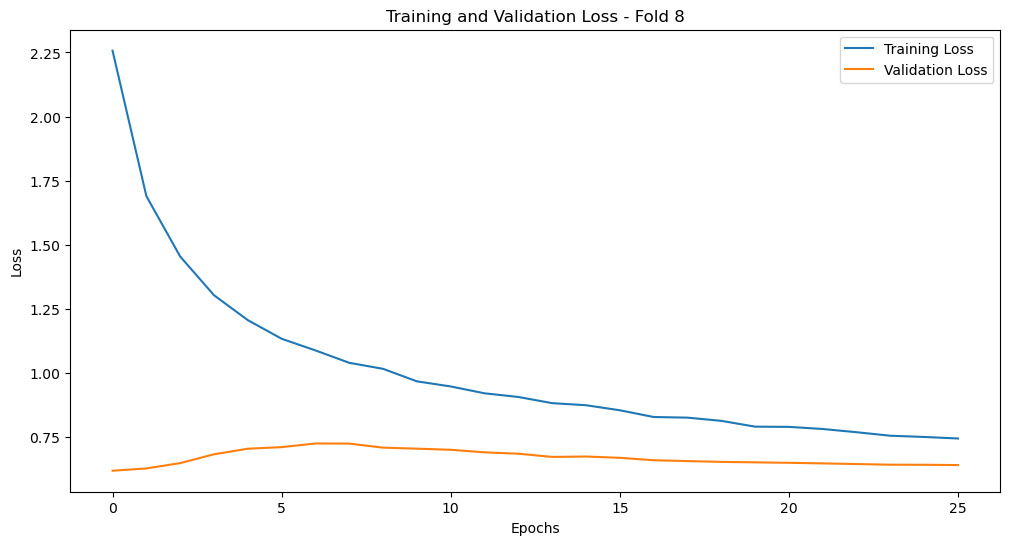

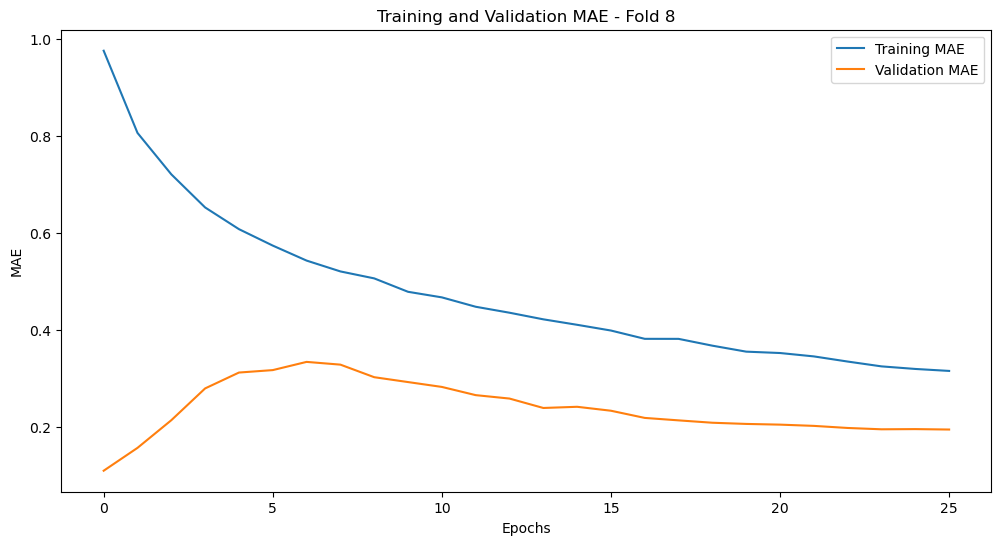

Fold Validation MAE: 0.11040952801704407
Epoch 1/550


C:\Users\Jojo\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 2.6281 - mae: 1.0937 - val_loss: 0.6292 - val_mae: 0.1544
Epoch 2/550
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.7005 - mae: 0.8127 - val_loss: 0.6164 - val_mae: 0.1081
Epoch 3/550
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.3900 - mae: 0.6900 - val_loss: 0.6127 - val_mae: 0.1027
Epoch 4/550
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.2284 - mae: 0.6157 - val_loss: 0.6136 - val_mae: 0.1118
Epoch 5/550
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1454 - mae: 0.5798 - val_loss: 0.6163 - val_mae: 0.1224
Epoch 6/550
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0446 - mae: 0.5230 - val_loss: 0.6182 - val_mae: 0.1315
Epoch 7/550
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0039 - mae: 0.4909 - val_loss: 0.6203 - val_mae: 0.1397
Epoch 8/550
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9451 - mae: 0.4610 - val_loss: 0.6233 - val_mae: 0.1488
Epoch 9/550
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9184 - mae: 0.

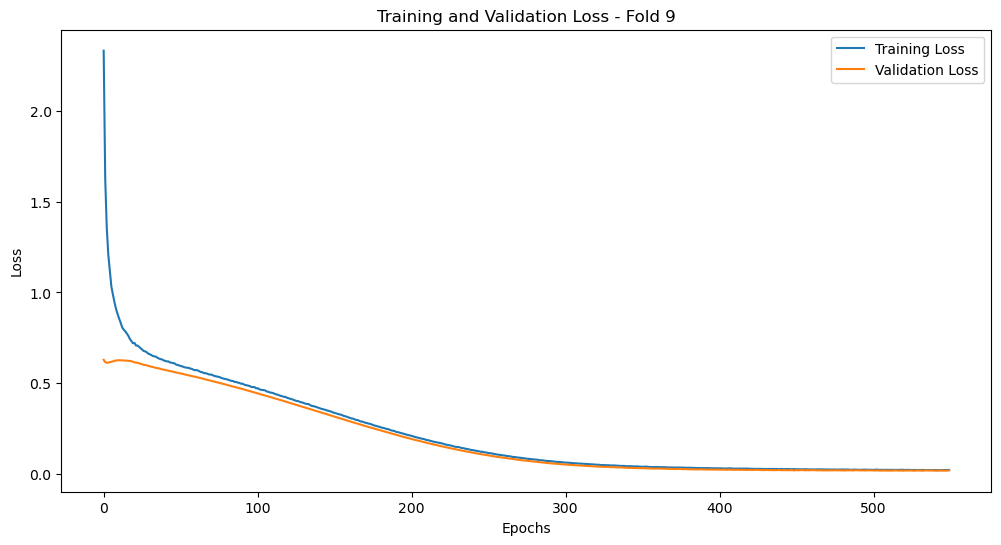

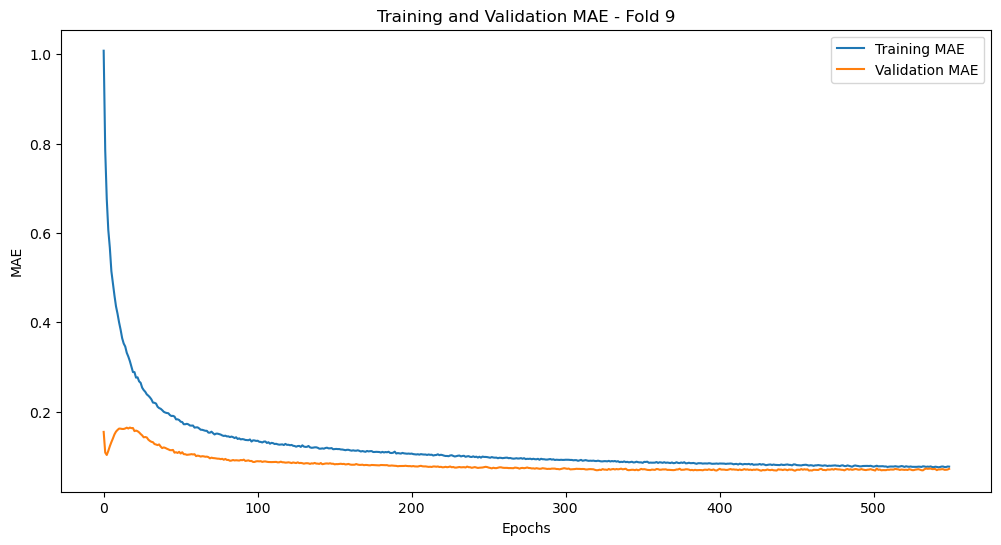

Fold Validation MAE: 0.06881148368120193
Epoch 1/550


C:\Users\Jojo\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 2.3827 - mae: 1.0388 - val_loss: 0.6269 - val_mae: 0.1242
Epoch 2/550
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.7156 - mae: 0.8256 - val_loss: 0.6245 - val_mae: 0.1201
Epoch 3/550
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.4351 - mae: 0.7116 - val_loss: 0.6251 - val_mae: 0.1276
Epoch 4/550
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.3155 - mae: 0.6559 - val_loss: 0.6272 - val_mae: 0.1390
Epoch 5/550
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.2377 - mae: 0.6204 - val_loss: 0.6328 - val_mae: 0.1572
Epoch 6/550
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1443 - mae: 0.5790 - val_loss: 0.6393 - val_mae: 0.1736
Epoch 7/550
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0663 - mae: 0.5396 - val_loss: 0.6453 - val_mae: 0.1867
Epoch 8/550
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0306 - mae: 0.5155 - val_loss: 0.6551 - val_mae: 0.2057
Epoch 9/550
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9971 - mae: 0.

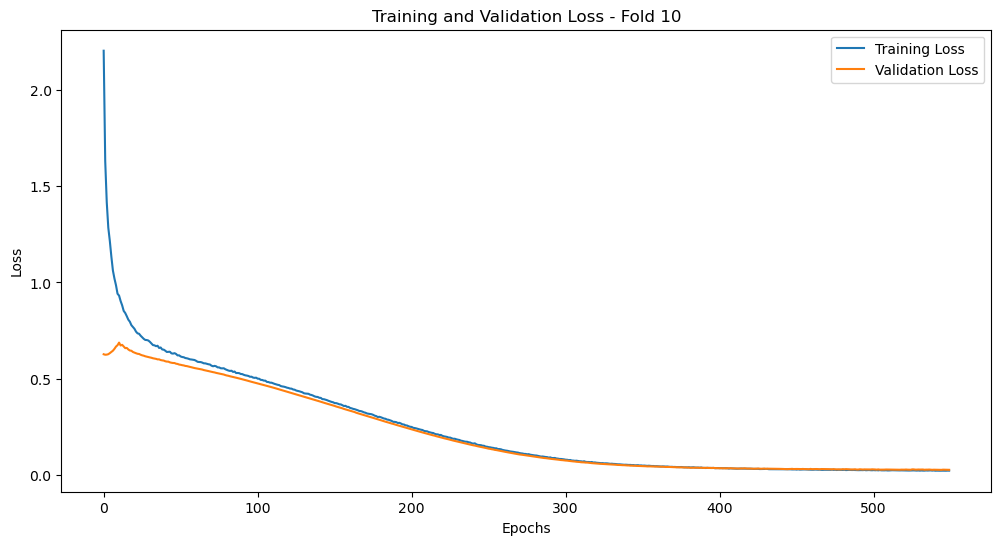

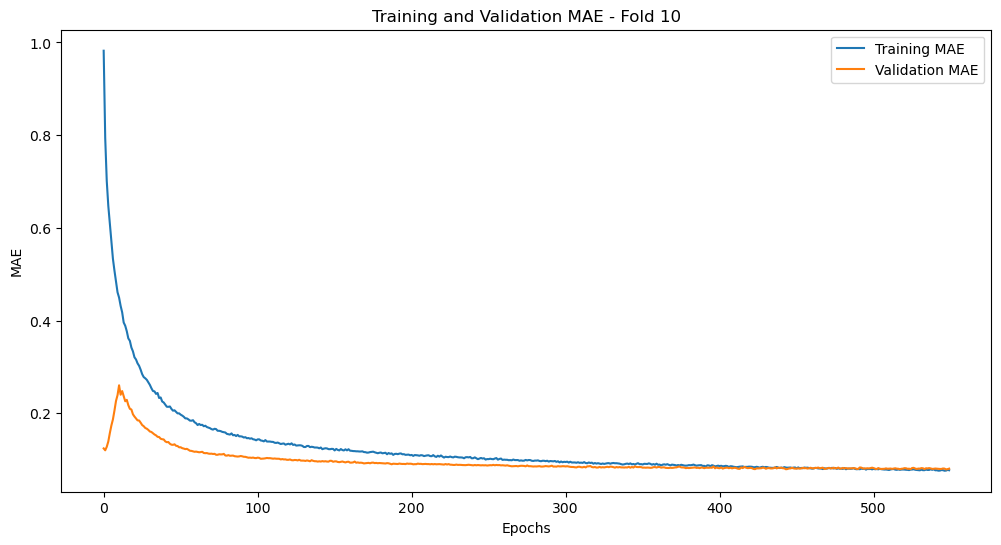

Fold Validation MAE: 0.07985295355319977

Mean Validation MAE: 0.08361120969057083
Standard Deviation of Validation MAE: 0.014157653568071778


In [14]:
# Criação do modelo

def create_model():
    model = Sequential([
        Dense(200, activation=LeakyReLU(negative_slope=0.01), kernel_regularizer=l1(0.0001), input_shape=(X_train.shape[1],)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(100, activation=LeakyReLU(negative_slope=0.01), kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.256),
        Dense(100, activation=LeakyReLU(negative_slope=0.01), kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.156),
        Dense(100, activation=LeakyReLU(negative_slope=0.01), kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.125),
        Dense(100, activation=LeakyReLU(negative_slope=0.01), kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.072),
        Dense(50, activation='relu'),
        BatchNormalization(),
        Dropout(0.025),
        Dense(1) 
    ])


    optimizer = Adam(learning_rate=0.0003)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

    return model

# K-Fold Cross Validation
kf = KFold(n_splits=10, shuffle=True, random_state=10)


val_mae_scores = []

# Loop para cada fold
for train_index, val_index in kf.split(X_train_scaled):
    X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]


    model = create_model()

    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)

    # Trainar o modelo
    history = model.fit(X_train_fold, y_train_fold, epochs=550, batch_size=470, validation_data=(X_val_fold, y_val_fold), callbacks=[early_stopping], verbose=1)

    # Plotting do training and validation loss para cada fold
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation Loss - Fold {len(val_mae_scores) + 1}')
    plt.legend()
    plt.show()

    # Plotting do training and validation MAE para cada fold
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.title(f'Training and Validation MAE - Fold {len(val_mae_scores) + 1}')
    plt.legend()
    plt.show()

    # Avaliar o modelo no conjunto de validação
    val_loss, val_mae = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    val_mae_scores.append(val_mae)
    print(f"Fold Validation MAE: {val_mae}")

# Calcular a média e desvio padrão dos scores de validação
mean_val_mae = np.mean(val_mae_scores)
std_val_mae = np.std(val_mae_scores)

print(f"\nMean Validation MAE: {mean_val_mae}")
print(f"Standard Deviation of Validation MAE: {std_val_mae}")


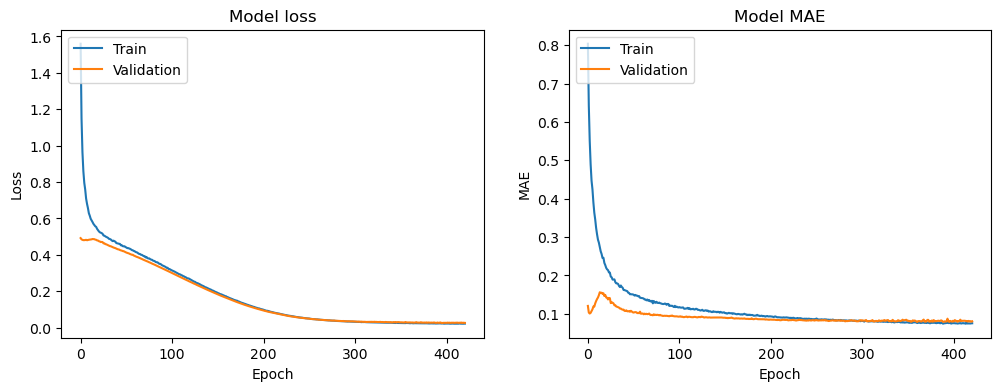

In [10]:
# Plot dos scores de loss e MAE

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')


plt.subplot(1, 2, 2)
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [14]:
# Standardizar os dados de teste para fazer previsões
test_data_scaled = scaler.transform(test_data.drop(columns=['id']))


In [15]:
# Gerar prediçoes
predictions = model.predict(test_data_scaled)

# Preparar submisao em csv
submission = pd.DataFrame({
    'id': test_data['id'],
    'value_550': predictions.flatten()
})


submission.to_csv('submission.csv', index=False)

print("Submission file created successfully!")


85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Submission file created successfully!


In [ ]:
## CODIGO DE TESTE ##

from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, SGD
import numpy as np


## CODIGO DE TESTE ##

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define the function to create your Keras model
def create_model(optimizer='adam', 
                 kernel_regularizer_1=0.0001, 
                 kernel_regularizer_2=0.001, 
                 kernel_regularizer_3=0.01, 
                 dropout_rate_1=0.5, 
                 dropout_rate_2=0.5, 
                 dropout_rate_3=0.2):
    model = Sequential([
        Dense(1280, activation='relu', kernel_regularizer=l2(kernel_regularizer_1), input_shape=(X_scaled.shape[1],)),
        BatchNormalization(),
        Dropout(dropout_rate_1),
        Dense(640, activation='relu', kernel_regularizer=l2(kernel_regularizer_2)),
        BatchNormalization(),
        Dropout(dropout_rate_2),
        Dense(320, activation='relu', kernel_regularizer=l2(kernel_regularizer_3)),
        BatchNormalization(),
        Dropout(dropout_rate_3),
        Dense(1)  # Output layer for regression
    ])
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    return model

# Create a KerasRegressor based on your Keras model
model = KerasRegressor(model=create_model, epochs=300, batch_size=32, verbose=0)

# Define the grid search parameters with correct prefixes
param_grid = {
    'model__optimizer': ['adam', 'sgd'],
    'model__kernel_regularizer_1': [0.0001, 0.001, 0.01],
    'model__kernel_regularizer_2': [0.0001, 0.001, 0.01],
    'model__kernel_regularizer_3': [0.0001, 0.001, 0.01],
    'model__dropout_rate_1': [0.3, 0.5, 0.7],
    'model__dropout_rate_2': [0.3, 0.5, 0.7],
    'model__dropout_rate_3': [0.2, 0.4, 0.6]
}

# Create GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)

# Fit GridSearchCV
grid_result = grid_search.fit(X_scaled, y)

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
